<a href="https://colab.research.google.com/github/abhee235/ML/blob/master/Tensor_with_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib import gridspec
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{: .1f}' .format 

In [0]:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
chdf["median_house_value"] /= 1000

chdf = chdf.reindex(np.random.permutation(chdf.index))



In [0]:
def preprocess_features(chdf) :
  selected_features = chdf[[
      "latitude",
      "longitude",
      "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"
  ]]
  
  processed_features = selected_features.copy()
  
  #synthetic features
  
  processed_features["rooms_per_person"] = chdf["total_rooms"] / chdf["population"]
  
  return processed_features
  
def preprocess_targets(chdf) :
  output_frame = pd.DataFrame()
  output_frame["median_house_value"] = chdf["median_house_value"]
  return output_frame

In [4]:
trn_ex = preprocess_features(chdf.head(12000))
trn_ex

trn_trg = preprocess_targets(chdf.head(12000))
trn_trg.describe()

vld_ex = preprocess_features(chdf.tail(5000))
vld_ex.describe()

vld_trg = preprocess_targets(chdf.tail(5000))
vld_trg.describe()

chdf["longitude"].head(12000).describe()
chdf["median_house_value"].head(12000).describe()

count    12000.0
mean       208.4
std        116.9
min         15.0
25%        119.7
50%        180.7
75%        266.2
max        500.0
Name: median_house_value, dtype: float64

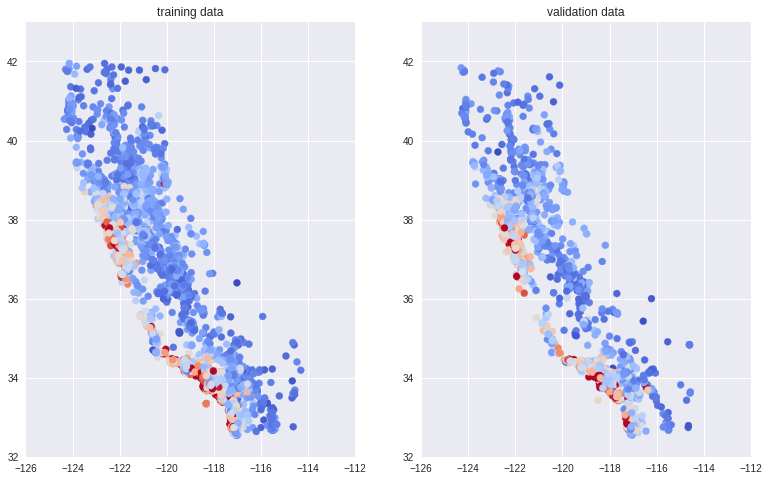

In [5]:
#plot Latitude/longitude vs median_house_value for data analysis 

plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_autoscaley_on(False)
ax.set_autoscalex_on(False)
ax.set_title("training data")
ax.set_xlim([-126,-112])
ax.set_ylim([32, 43])
plt.scatter(trn_ex["longitude"],
           trn_ex["latitude"],
           cmap= 'coolwarm',
           c = trn_trg["median_house_value"]/ trn_trg["median_house_value"].max())
#_ =plt.plot()

#plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,2)
ax.set_autoscaley_on(False)
ax.set_autoscalex_on(False)
ax.set_title("validation data")
ax.set_xlim([-126,-112])
ax.set_ylim([32, 43])
plt.scatter(vld_ex["longitude"],
           vld_ex["latitude"],
           cmap= 'coolwarm',
           c = vld_trg["median_house_value"]/ vld_trg["median_house_value"].max())
_ =plt.plot()

In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle= True, num_epochs = None):
  features = {key: np.array(value) for key,value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds.shuffle(buffer_size = 10000)
    
 
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [0]:
def construct_feature_columns(my_features):
  return set([tf.feature_column.numeric_column(item) for item in my_features])

In [0]:
def train_model(learning_rate, steps, batch_size):
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,0.5)
  
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(trn_ex),
    optimizer = my_optimizer)
  
  periods = 10
  steps_per_period = steps / periods
  
  training_input_fn = lambda : my_input_fn(trn_ex, trn_trg, batch_size)
  
  validation_input_fn = lambda : my_input_fn(vld_ex, vld_trg, batch_size)
  
  for period in range(0,periods):
    linear_regressor.train(
    input_fn = training_input_fn,
    steps = steps_per_period)
    
    training_prediction_fn = lambda : my_input_fn(trn_ex, trn_trg, shuffle = False, num_epochs = 1)
    validation_prediction_fn = lambda : my_input_fn(vld_ex, vld_trg,shuffle= False, num_epochs = 1)
    
    training_prediction = linear_regressor.predict(input_fn = training_prediction_fn)
    
    training_prediction = np.array([item["predictions"][0] for item in training_prediction])
    
    validation_prediction = linear_regressor.predict(input_fn = validation_prediction_fn)
    validation_prediction = np.array([item["predictions"][0] for item in validation_prediction])
    
    
    trnMSE = metrics.mean_squared_error(training_prediction, trn_trg)
    trnRMSE = math.sqrt(trnMSE)
    
    vldMSE = metrics.mean_squared_error(validation_prediction, vld_trg)
    vldRMSE = math.sqrt(vldMSE)
    
    print("Root Mean Squared Error (on training data): %0.3f" %trnRMSE)
    print("Root Mean Squared Error (on validation data): %0.3f" %vldRMSE)
    
    # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(trnRMSE, label="training")
  plt.plot(vldRMSE, label="validation")
  plt.legend()
    
  return linear_regressor

Root Mean Squared Error (on training data): 225.426
Root Mean Squared Error (on validation data): 220.762
Root Mean Squared Error (on training data): 212.871
Root Mean Squared Error (on validation data): 208.272
Root Mean Squared Error (on training data): 201.679
Root Mean Squared Error (on validation data): 197.047
Root Mean Squared Error (on training data): 192.924
Root Mean Squared Error (on validation data): 188.176
Root Mean Squared Error (on training data): 186.133
Root Mean Squared Error (on validation data): 181.208
Root Mean Squared Error (on training data): 180.890
Root Mean Squared Error (on validation data): 175.748
Root Mean Squared Error (on training data): 176.618
Root Mean Squared Error (on validation data): 171.209
Root Mean Squared Error (on training data): 173.579
Root Mean Squared Error (on validation data): 167.892
Root Mean Squared Error (on training data): 171.237
Root Mean Squared Error (on validation data): 165.234
Root Mean Squared Error (on training data): 16

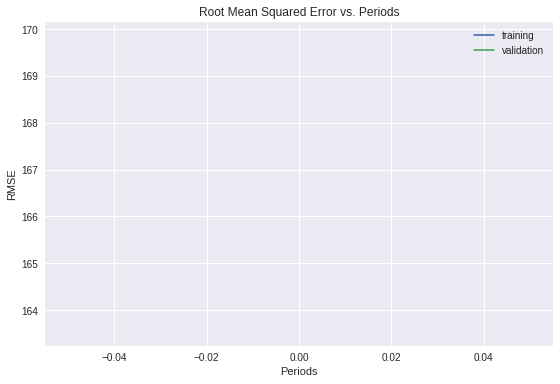

In [67]:
linear_regressor = train_model(0.0001,1000,1)